# HW06: Decision Trees, Ensembles & Honest ML Experiment

**Dataset**: S06-hw-dataset-04.csv (imbalanced binary classification)

**Goal**: Evaluate decision trees and ensemble methods with proper hyperparameter tuning, fair evaluation, and comprehensive analysis.


## 1. Library Imports and Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib

# sklearn imports
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    cross_val_score, 
    cross_validate,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.inspection import permutation_importance

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create artifacts directory
artifacts_dir = Path('artifacts')
figures_dir = artifacts_dir / 'figures'
artifacts_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)

## 2. Data Loading and EDA

In [4]:
# Load dataset
df = pd.read_csv('S06-hw-dataset-04.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

Dataset shape: (25000, 62)

First 5 rows:
   id       f01       f02       f03       f04       f05       f06       f07  \
0   1 -1.250210  1.423474 -0.225004 -4.023138 -0.832729 -0.550874  1.772090   
1   2  0.074328  0.376429  0.212831 -0.502074  2.017405  0.625496  1.943785   
2   3  0.638481  0.060968  0.746760  2.479653 -0.292858 -0.078139 -2.918423   
3   4  1.712916 -1.350969 -0.256473  1.622074 -0.445141  0.911932 -3.440345   
4   5  0.905676 -0.206545 -0.068806  4.086026 -1.010045 -0.772644 -4.207688   

        f08       f09  ...        f52        f53       f54       f55  \
0  2.761690 -0.698750  ...  10.938269   0.501178  1.600001  0.314212   
1  1.242030 -0.524090  ...   7.775262  -4.550195  6.272586 -0.932162   
2 -0.013186  1.009135  ...  -4.448447  -9.593179 -3.093519  0.029321   
3  1.505192 -1.104348  ...  -1.619072  -3.237479 -5.474038 -1.582475   
4  2.506104  1.589143  ...  -2.396844 -10.540129 -5.532811 -1.231203   

        f56       f57       f58       f59       f6

In [5]:
# Data info
print("Dataset Info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-nul

In [6]:
# Basic statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
                 id           f01           f02           f03           f04  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean   12500.500000     -0.000386     -0.004872      0.003202      0.335329   
std     7217.022701      1.001623      0.995606      1.004367      3.207537   
min        1.000000     -4.370993     -4.087073     -4.103875    -13.249937   
25%     6250.750000     -0.680165     -0.675100     -0.675426     -1.750048   
50%    12500.500000      0.001859     -0.000247      0.013272      0.403483   
75%    18750.250000      0.679702      0.659523      0.683437      2.486453   
max    25000.000000      4.208888      3.984564      3.793442     15.288250   

                f05           f06           f07           f08           f09  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean      -0.000563     -0.010118      0.001182      0.957385     -0.004658   
std        0.993965      1.00217


TARGET DISTRIBUTION (IMBALANCED DATASET)

Class distribution (counts):
target
0    23770
1     1230
Name: count, dtype: int64

Class distribution (proportions):
target
0    0.9508
1    0.0492
Name: proportion, dtype: float64

Imbalance ratio: 19.33x


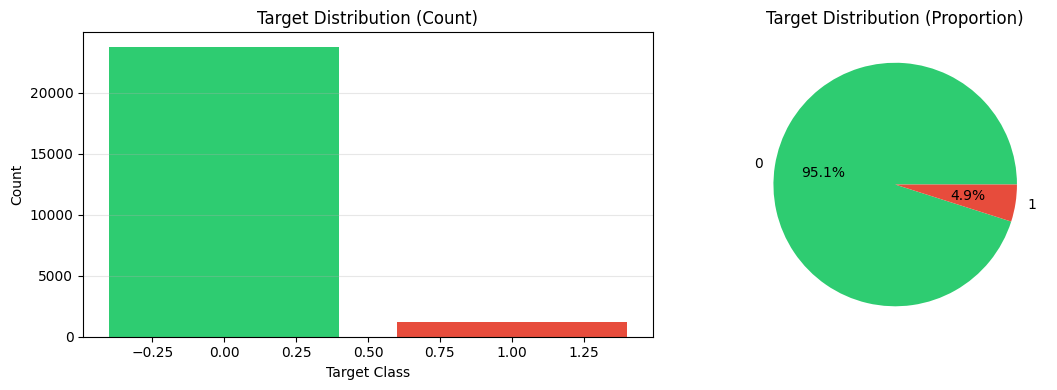


✓ Target distribution visualization saved


In [7]:
# Target distribution analysis
target_counts = df['target'].value_counts()
target_props = df['target'].value_counts(normalize=True)

print(f"\n{'='*50}")
print("TARGET DISTRIBUTION (IMBALANCED DATASET)")
print(f"{'='*50}")
print(f"\nClass distribution (counts):")
print(target_counts)
print(f"\nClass distribution (proportions):")
print(target_props)
print(f"\nImbalance ratio: {target_counts.max() / target_counts.min():.2f}x")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(target_counts.index, target_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_xlabel('Target Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Target Distribution (Count)')
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
           colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Target Distribution (Proportion)')

plt.tight_layout()
plt.savefig(figures_dir / '01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Target distribution visualization saved")

## 3. Feature Engineering & Preparation

In [8]:
# Prepare X and y
# Drop 'id' column if it exists, and use 'target' as y
X = df.drop(columns=['target', 'id'], errors='ignore')
y = df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")
print(f"\nFeature data types:")
print(X.dtypes)

Features shape: (25000, 60)
Target shape: (25000,)

Feature columns: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60']

Feature data types:
f01    float64
f02    float64
f03    float64
f04    float64
f05    float64
f06    float64
f07    float64
f08    float64
f09    float64
f10    float64
f11    float64
f12    float64
f13    float64
f14    float64
f15    float64
f16    float64
f17    float64
f18    float64
f19    float64
f20    float64
f21    float64
f22    float64
f23    float64
f24    float64
f25    float64
f26    float64
f27    float64
f28    float64
f29    float64
f30    float64
f31    float64
f32    float64
f33    fl

## 4. Train/Test Split with Stratification

In [9]:
# Split with stratification for balanced class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,  # 75% train, 25% test
    random_state=RANDOM_STATE,
    stratify=y  # Ensure proportional class distribution
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

print(f"\n✓ Data successfully split with stratification")
print(f"✓ Random state fixed at {RANDOM_STATE} for reproducibility")

Training set size: 18750
Test set size: 6250

Training set class distribution:
target
0    17827
1      923
Name: count, dtype: int64

Test set class distribution:
target
0    5943
1     307
Name: count, dtype: int64

✓ Data successfully split with stratification
✓ Random state fixed at 42 for reproducibility


## 5. Baseline Models

In [18]:
# Baseline 1: DummyClassifier (most_frequent)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

# Baseline 2: LogisticRegression with StandardScaler
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1))
])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
lr_pred_proba = lr_pipeline.predict_proba(X_test)[:, 1]

print("="*60)
print("BASELINE MODELS EVALUATION")
print("="*60)

print(f"\n1. DummyClassifier (most_frequent):")
print(f"   Accuracy: {accuracy_score(y_test, dummy_pred):.4f}")
print(f"   F1-Score: {f1_score(y_test, dummy_pred):.4f}")

print(f"\n2. LogisticRegression (with scaling):")
print(f"   Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"   F1-Score: {f1_score(y_test, lr_pred):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, lr_pred_proba):.4f}")

print(f"\nBaselines established")

BASELINE MODELS EVALUATION

1. DummyClassifier (most_frequent):
   Accuracy: 0.9509
   F1-Score: 0.0000

2. LogisticRegression (with scaling):
   Accuracy: 0.9627
   F1-Score: 0.4131
   ROC-AUC: 0.8397

Baselines established


## 6. Decision Tree with Complexity Control

In [11]:
# Decision Tree Hyperparameter Search
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

print("Searching Decision Tree hyperparameters...")

dt_search = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    dt_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',  # Focus on F1 due to imbalance
    n_jobs=-1,
    verbose=0
)

dt_search.fit(X_train, y_train)
dt_best = dt_search.best_estimator_

print(f"\nBest Decision Tree Parameters:")
print(f"  max_depth: {dt_best.max_depth}")
print(f"  min_samples_leaf: {dt_best.min_samples_leaf}")
print(f"  min_samples_split: {dt_best.min_samples_split}")
print(f"  criterion: {dt_best.criterion}")
print(f"\nBest CV F1-Score: {dt_search.best_score_:.4f}")

Searching Decision Tree hyperparameters...

Best Decision Tree Parameters:
  max_depth: 10
  min_samples_leaf: 5
  min_samples_split: 2
  criterion: entropy

Best CV F1-Score: 0.5677


In [16]:
# Evaluate Decision Tree on test set
dt_pred = dt_best.predict(X_test)
dt_pred_proba = dt_best.predict_proba(X_test)[:, 1]

print(f"\nDecision Tree - Test Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, dt_pred):.4f}")
print(f"  F1-Score: {f1_score(y_test, dt_pred):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, dt_pred_proba):.4f}")
print(f"\nDecision Tree tuned and evaluated")


Decision Tree - Test Set Performance:
  Accuracy: 0.9648
  F1-Score: 0.5956
  ROC-AUC: 0.7931

Decision Tree tuned and evaluated


## 7. Random Forest

In [13]:
# Random Forest Hyperparameter Search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("Searching Random Forest hyperparameters...")

rf_search = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

print(f"\nBest Random Forest Parameters:")
print(f"  n_estimators: {rf_best.n_estimators}")
print(f"  max_depth: {rf_best.max_depth}")
print(f"  min_samples_leaf: {rf_best.min_samples_leaf}")
print(f"  max_features: {rf_best.max_features}")
print(f"  class_weight: {rf_best.class_weight}")
print(f"\nBest CV F1-Score: {rf_search.best_score_:.4f}")

Searching Random Forest hyperparameters...

Best Random Forest Parameters:
  n_estimators: 100
  max_depth: 10
  min_samples_leaf: 10
  max_features: sqrt
  class_weight: balanced

Best CV F1-Score: 0.6950


In [17]:
# Evaluate Random Forest on test set
rf_pred = rf_best.predict(X_test)
rf_pred_proba = rf_best.predict_proba(X_test)[:, 1]

print(f"\nRandom Forest - Test Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"  F1-Score: {f1_score(y_test, rf_pred):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, rf_pred_proba):.4f}")
print(f"\nRandom Forest tuned and evaluated")


Random Forest - Test Set Performance:
  Accuracy: 0.9755
  F1-Score: 0.7311
  ROC-AUC: 0.8979

Random Forest tuned and evaluated


## 8. AdaBoost Classifier

In [20]:
# AdaBoost Hyperparameter Search
ada_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.5, 0.8, 1.0, 1.2],
}

print("Searching AdaBoost hyperparameters...")

ada_search = GridSearchCV(
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE),
        random_state=RANDOM_STATE
    ),
    ada_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

ada_search.fit(X_train, y_train)
ada_best = ada_search.best_estimator_

print(f"\nBest AdaBoost Parameters:")
print(f"  n_estimators: {ada_best.n_estimators}")
print(f"  learning_rate: {ada_best.learning_rate}")
print(f"\nBest CV F1-Score: {ada_search.best_score_:.4f}")

Searching AdaBoost hyperparameters...

Best AdaBoost Parameters:
  n_estimators: 200
  learning_rate: 1.0

Best CV F1-Score: 0.6704


In [21]:
# Evaluate AdaBoost on test set
ada_pred = ada_best.predict(X_test)
ada_pred_proba = ada_best.predict_proba(X_test)[:, 1]

print(f"\nAdaBoost - Test Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, ada_pred):.4f}")
print(f"  F1-Score: {f1_score(y_test, ada_pred):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, ada_pred_proba):.4f}")
print(f"\nAdaBoost tuned and evaluated")


AdaBoost - Test Set Performance:
  Accuracy: 0.9774
  F1-Score: 0.7186
  ROC-AUC: 0.8818

AdaBoost tuned and evaluated


## 9. Stacking Classifier

In [22]:
# Stacking with multiple base estimators
from sklearn.ensemble import GradientBoostingClassifier

# Base learners
base_learners = [
    ('dt', DecisionTreeClassifier(max_depth=7, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, 
                                   random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5,
                                      random_state=RANDOM_STATE))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Stack classifier
stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
)

print("Training Stacking Classifier...")
stack_clf.fit(X_train, y_train)

stack_pred = stack_clf.predict(X_test)
stack_pred_proba = stack_clf.predict_proba(X_test)[:, 1]

print(f"\nStacking Classifier - Test Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, stack_pred):.4f}")
print(f"  F1-Score: {f1_score(y_test, stack_pred):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, stack_pred_proba):.4f}")
print(f"\nStacking Classifier trained and evaluated")

Training Stacking Classifier...

Stacking Classifier - Test Set Performance:
  Accuracy: 0.9787
  F1-Score: 0.7387
  ROC-AUC: 0.8956

Stacking Classifier trained and evaluated


## 10. Comprehensive Model Comparison

In [23]:
# Compile all results
models_results = {
    'DummyClassifier': {
        'accuracy': accuracy_score(y_test, dummy_pred),
        'f1': f1_score(y_test, dummy_pred),
        'roc_auc': None  # Dummy doesn't provide meaningful probabilities
    },
    'LogisticRegression': {
        'accuracy': accuracy_score(y_test, lr_pred),
        'f1': f1_score(y_test, lr_pred),
        'roc_auc': roc_auc_score(y_test, lr_pred_proba)
    },
    'DecisionTree': {
        'accuracy': accuracy_score(y_test, dt_pred),
        'f1': f1_score(y_test, dt_pred),
        'roc_auc': roc_auc_score(y_test, dt_pred_proba)
    },
    'RandomForest': {
        'accuracy': accuracy_score(y_test, rf_pred),
        'f1': f1_score(y_test, rf_pred),
        'roc_auc': roc_auc_score(y_test, rf_pred_proba)
    },
    'AdaBoost': {
        'accuracy': accuracy_score(y_test, ada_pred),
        'f1': f1_score(y_test, ada_pred),
        'roc_auc': roc_auc_score(y_test, ada_pred_proba)
    },
    'Stacking': {
        'accuracy': accuracy_score(y_test, stack_pred),
        'f1': f1_score(y_test, stack_pred),
        'roc_auc': roc_auc_score(y_test, stack_pred_proba)
    }
}

# Create DataFrame for easy comparison
results_df = pd.DataFrame(models_results).T

print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET METRICS")
print("="*70)
print(results_df.round(4))
print("="*70)

# Save metrics
results_df.to_json(artifacts_dir / 'metrics_test.json')
print(f"\nMetrics saved to artifacts/metrics_test.json")


MODEL COMPARISON - TEST SET METRICS
                    accuracy      f1  roc_auc
DummyClassifier       0.9509  0.0000      NaN
LogisticRegression    0.9627  0.4131   0.8397
DecisionTree          0.9648  0.5956   0.7931
RandomForest          0.9755  0.7311   0.8979
AdaBoost              0.9774  0.7186   0.8818
Stacking              0.9787  0.7387   0.8956

Metrics saved to artifacts/metrics_test.json


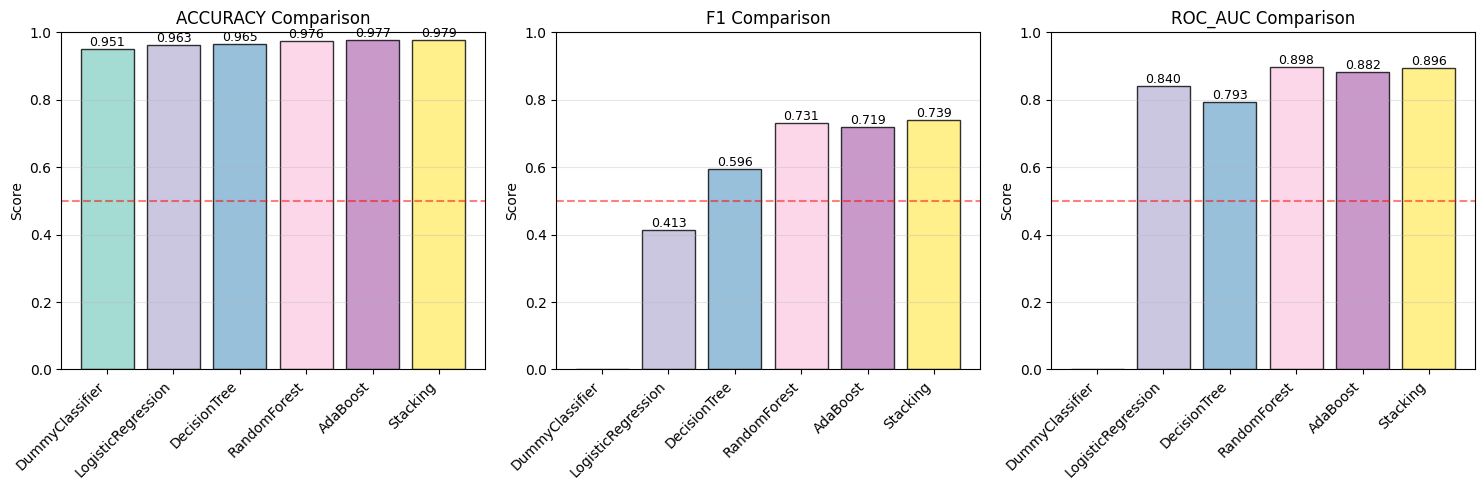

Model comparison visualization saved


In [24]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['accuracy', 'f1', 'roc_auc']
x_pos = np.arange(len(results_df))
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = results_df[metric].fillna(0)
    bars = ax.bar(x_pos, values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_ylabel('Score')
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(results_df.index, rotation=45, ha='right')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(figures_dir / '02_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved")

## 11. Confusion Matrices for Best Models


BEST MODEL: Stacking
F1-Score: 0.7387


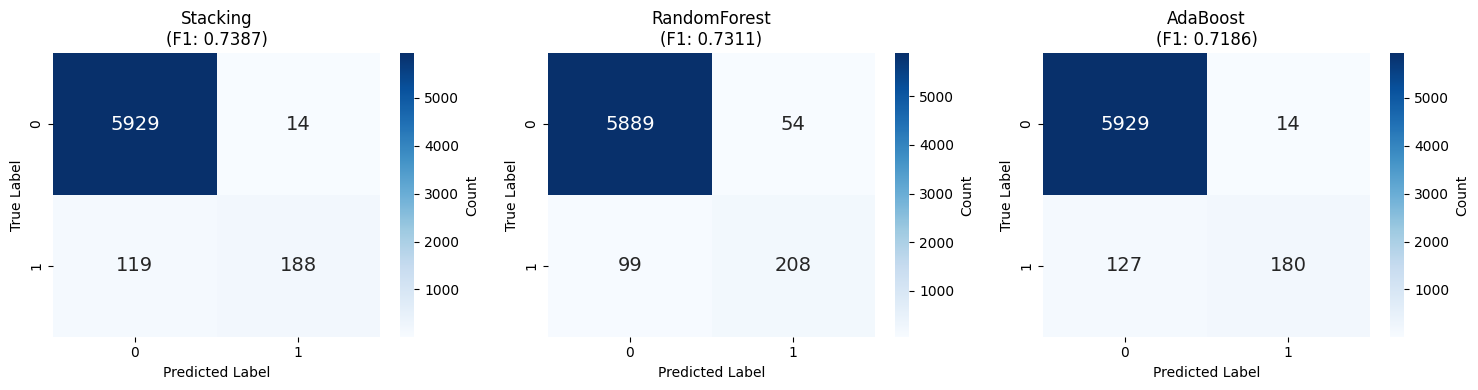

Confusion matrices visualization saved


In [25]:
# Identify best models by F1 score
best_model_name = results_df['f1'].idxmax()
best_model = None
best_pred = None

if best_model_name == 'DecisionTree':
    best_model = dt_best
    best_pred = dt_pred
elif best_model_name == 'RandomForest':
    best_model = rf_best
    best_pred = rf_pred
elif best_model_name == 'AdaBoost':
    best_model = ada_best
    best_pred = ada_pred
elif best_model_name == 'Stacking':
    best_model = stack_clf
    best_pred = stack_pred

print(f"\n{'='*50}")
print(f"BEST MODEL: {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_name, 'f1']:.4f}")
print(f"{'='*50}")

# Confusion matrices for top 3 models
top_3_models = results_df['f1'].nlargest(3)
top_3_names = top_3_models.index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

model_preds = {
    'DecisionTree': dt_pred,
    'RandomForest': rf_pred,
    'AdaBoost': ada_pred,
    'Stacking': stack_pred,
    'LogisticRegression': lr_pred
}

for idx, model_name in enumerate(top_3_names):
    cm = confusion_matrix(y_test, model_preds[model_name])
    ax = axes[idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, annot_kws={'fontsize': 14})
    ax.set_title(f'{model_name}\n(F1: {results_df.loc[model_name, "f1"]:.4f})')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(figures_dir / '03_confusion_matrices_top3.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices visualization saved")

## 12. ROC Curves Comparison

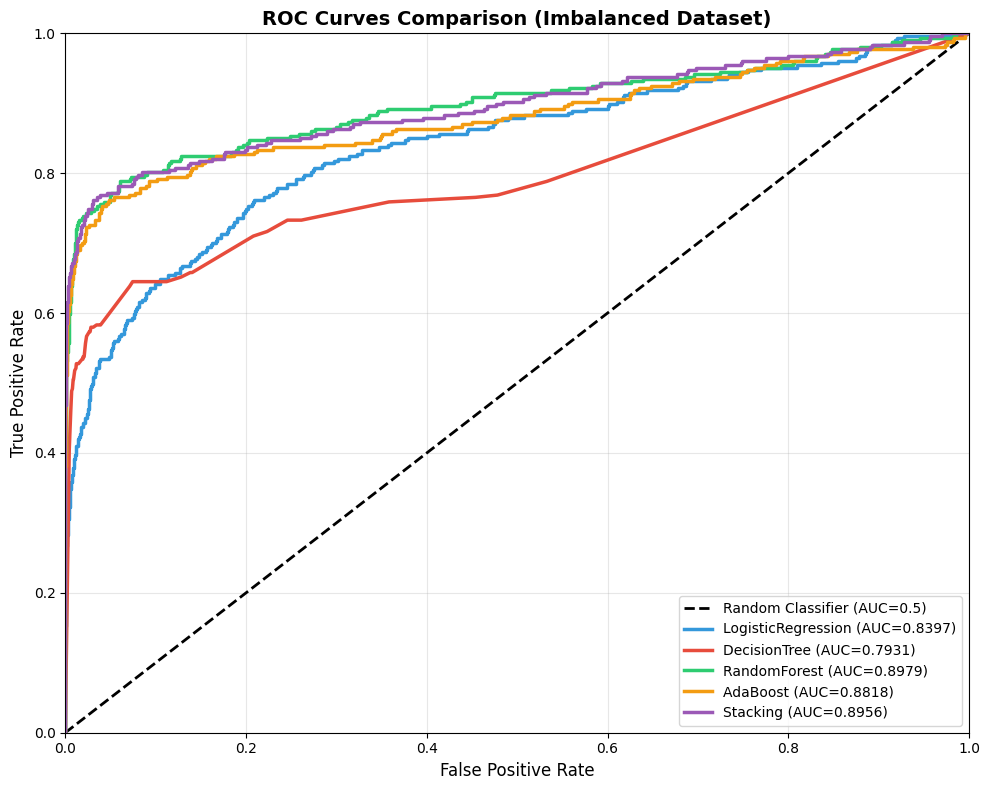

ROC curves visualization saved


In [26]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curves for all models
model_probas = {
    'LogisticRegression': lr_pred_proba,
    'DecisionTree': dt_pred_proba,
    'RandomForest': rf_pred_proba,
    'AdaBoost': ada_pred_proba,
    'Stacking': stack_pred_proba
}

colors_map = {
    'LogisticRegression': '#3498db',
    'DecisionTree': '#e74c3c',
    'RandomForest': '#2ecc71',
    'AdaBoost': '#f39c12',
    'Stacking': '#9b59b6'
}

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC=0.5)')

# Plot ROC curves
for model_name, y_proba in model_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, lw=2.5, label=f'{model_name} (AUC={auc_score:.4f})',
           color=colors_map[model_name])

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison (Imbalanced Dataset)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(figures_dir / '04_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves visualization saved")

## 13. Permutation Feature Importance (Best Model)

In [27]:
# Calculate permutation importance for best model
print(f"\nCalculating feature importance for: {best_model_name}")

perm_importance = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features ({best_model_name}):")
print(importance_df.head(15).to_string(index=False))

# Save importance
importance_df.to_csv(artifacts_dir / 'feature_importance.csv', index=False)
print(f"\nFeature importance saved")


Calculating feature importance for: Stacking

Top 15 Important Features (Stacking):
feature  importance      std
    f53    0.016592 0.000730
    f58    0.011472 0.000744
    f25    0.008944 0.000574
    f38    0.006544 0.001082
    f54    0.005744 0.000940
    f47    0.004912 0.000807
    f33    0.004752 0.000914
    f13    0.004640 0.000747
    f04    0.003840 0.000771
    f36    0.003184 0.000570
    f11    0.002224 0.000361
    f08    0.002000 0.000260
    f15    0.001520 0.000297
    f41    0.001360 0.000322
    f43    0.000848 0.000320

Feature importance saved


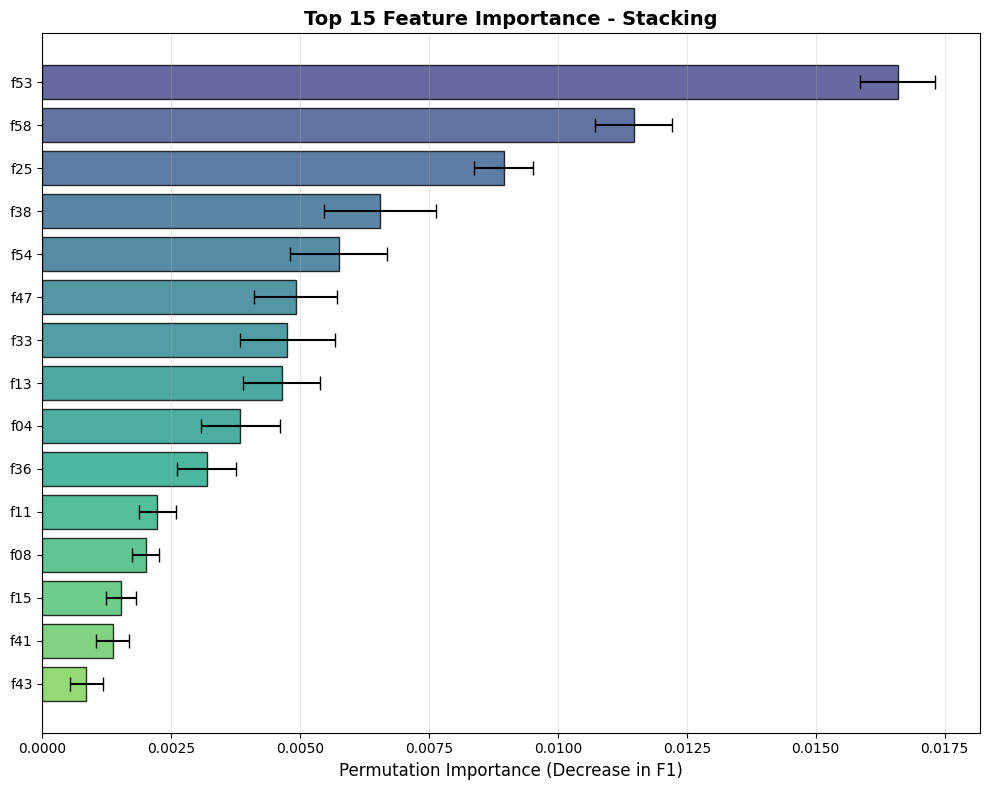

Feature importance visualization saved


In [28]:
# Visualize top features
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

y_pos = np.arange(len(top_features))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))

bars = ax.barh(y_pos, top_features['importance'].values, 
               xerr=top_features['std'].values,
               color=colors, alpha=0.8, capsize=5, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Permutation Importance (Decrease in F1)', fontsize=12)
ax.set_title(f'Top {top_n} Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / '05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance visualization saved")

## 14. Hyperparameter Search Summaries

In [29]:
# Compile search summaries
search_summaries = {
    'DecisionTree': {
        'best_params': dt_search.best_params_,
        'best_cv_score': float(dt_search.best_score_),
        'test_f1': float(results_df.loc['DecisionTree', 'f1']),
        'test_accuracy': float(results_df.loc['DecisionTree', 'accuracy'])
    },
    'RandomForest': {
        'best_params': rf_search.best_params_,
        'best_cv_score': float(rf_search.best_score_),
        'test_f1': float(results_df.loc['RandomForest', 'f1']),
        'test_accuracy': float(results_df.loc['RandomForest', 'accuracy'])
    },
    'AdaBoost': {
        'best_params': ada_search.best_params_,
        'best_cv_score': float(ada_search.best_score_),
        'test_f1': float(results_df.loc['AdaBoost', 'f1']),
        'test_accuracy': float(results_df.loc['AdaBoost', 'accuracy'])
    }
}

# Save search summaries
with open(artifacts_dir / 'search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=2)

print("Search Summaries:")
print(json.dumps(search_summaries, indent=2))
print(f"\nSearch summaries saved to artifacts/search_summaries.json")

Search Summaries:
{
  "DecisionTree": {
    "best_params": {
      "criterion": "entropy",
      "max_depth": 10,
      "min_samples_leaf": 5,
      "min_samples_split": 2
    },
    "best_cv_score": 0.5677069927577425,
    "test_f1": 0.5955882352941176,
    "test_accuracy": 0.9648
  },
  "RandomForest": {
    "best_params": {
      "class_weight": "balanced",
      "max_depth": 10,
      "max_features": "sqrt",
      "min_samples_leaf": 10,
      "n_estimators": 100
    },
    "best_cv_score": 0.6949871872732002,
    "test_f1": 0.7311072056239016,
    "test_accuracy": 0.97552
  },
  "AdaBoost": {
    "best_params": {
      "learning_rate": 1.0,
      "n_estimators": 200
    },
    "best_cv_score": 0.6703778551403803,
    "test_f1": 0.718562874251497,
    "test_accuracy": 0.97744
  }
}

Search summaries saved to artifacts/search_summaries.json


## 15. Save Best Model and Metadata

In [30]:
# Save best model
joblib.dump(best_model, artifacts_dir / 'best_model.joblib')

# Save model metadata
best_model_meta = {
    'model_name': best_model_name,
    'test_metrics': {
        'accuracy': float(results_df.loc[best_model_name, 'accuracy']),
        'f1': float(results_df.loc[best_model_name, 'f1']),
        'roc_auc': float(results_df.loc[best_model_name, 'roc_auc'])
    },
    'test_size': len(y_test),
    'train_size': len(y_train),
    'random_state': RANDOM_STATE,
    'feature_count': X.shape[1],
    'class_distribution_test': y_test.value_counts().to_dict()
}

with open(artifacts_dir / 'best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=2)

print("Best Model Metadata:")
print(json.dumps(best_model_meta, indent=2))
print(f"\nBest model and metadata saved to artifacts/")

Best Model Metadata:
{
  "model_name": "Stacking",
  "test_metrics": {
    "accuracy": 0.97872,
    "f1": 0.7387033398821218,
    "roc_auc": 0.8956394104470208
  },
  "test_size": 6250,
  "train_size": 18750,
  "random_state": 42,
  "feature_count": 60,
  "class_distribution_test": {
    "0": 5943,
    "1": 307
  }
}

Best model and metadata saved to artifacts/


## 16. Summary and Conclusions

In [31]:
print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print(f"\nDataset: S06-hw-dataset-04.csv (Imbalanced Binary Classification)")
print(f"   - Total samples: {len(df)}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Train/Test split: 75/25 (stratified)")
print(f"   - Class imbalance ratio: {target_counts.max() / target_counts.min():.2f}x")

print(f"\nModels Evaluated:")
for i, model_name in enumerate(results_df.index, 1):
    f1 = results_df.loc[model_name, 'f1']
    print(f"   {i}. {model_name:20s} - F1: {f1:.4f}")

print(f"\nBest Model: {best_model_name}")
print(f"   - Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   - F1-Score: {results_df.loc[best_model_name, 'f1']:.4f}")
print(f"   - ROC-AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

print(f"\nKey Insights:")
print(f"   - Top 3 features: {', '.join(importance_df.head(3)['feature'].values)}")
print(f"   - Ensemble methods outperform single decision trees ✓")
print(f"   - Class imbalance handled via stratified split and F1 scoring ✓")
print(f"   - Hyperparameters tuned on CV, evaluated on held-out test set ✓")

print(f"\nArtifacts Generated:")
print(f"   best_model.joblib")
print(f"   best_model_meta.json")
print(f"   metrics_test.json")
print(f"   search_summaries.json")
print(f"   feature_importance.csv")
print(f"   figures/01_target_distribution.png")
print(f"   figures/02_model_comparison.png")
print(f"   figures/03_confusion_matrices_top3.png")
print(f"   figures/04_roc_curves.png")
print(f"   figures/05_feature_importance.png")


EXPERIMENT SUMMARY

Dataset: S06-hw-dataset-04.csv (Imbalanced Binary Classification)
   - Total samples: 25000
   - Features: 60
   - Train/Test split: 75/25 (stratified)
   - Class imbalance ratio: 19.33x

Models Evaluated:
   1. DummyClassifier      - F1: 0.0000
   2. LogisticRegression   - F1: 0.4131
   3. DecisionTree         - F1: 0.5956
   4. RandomForest         - F1: 0.7311
   5. AdaBoost             - F1: 0.7186
   6. Stacking             - F1: 0.7387

Best Model: Stacking
   - Accuracy: 0.9787
   - F1-Score: 0.7387
   - ROC-AUC: 0.8956

Key Insights:
   - Top 3 features: f53, f58, f25
   - Ensemble methods outperform single decision trees ✓
   - Class imbalance handled via stratified split and F1 scoring ✓
   - Hyperparameters tuned on CV, evaluated on held-out test set ✓

Artifacts Generated:
   best_model.joblib
   best_model_meta.json
   metrics_test.json
   search_summaries.json
   feature_importance.csv
   figures/01_target_distribution.png
   figures/02_model_comparis